Notebook
https://www.learnpytorch.io/03_pytorch_computer_vision/ 

## 0. Setup

In [36]:
%pip -q install torch torchvision torchaudio torchmetrics pandas numpy matplotlib tqdm scikit-learn mlxtend;


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import torch
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device


# Setup random seed
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_everything()

## 1. Data

We will use Fashion MNIST.

In [4]:
train_data = datasets.FashionMNIST(
    root="data",  # where to save the data
    train=True,  # train or test set
    download=True,  # download if not available locally
    transform=ToTensor(),  # transform input images to tensors
    target_transform=None,  # transform targets (we don't need this here)
)

test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

print(f"Train data shape: {train_data.data.shape}")
print(f"Test data shape: {test_data.data.shape}")

Train data shape: torch.Size([60000, 28, 28])
Test data shape: torch.Size([10000, 28, 28])


### Check data shape

In [5]:
classes = train_data.classes
class_to_idx = train_data.class_to_idx
sample_img, sample_label = train_data[0]

print(f"Classes: {classes}")
print(f"Class to idx: {class_to_idx}")
print(f"Sample image shape: {sample_img.shape}")
print(f"Sample label: {sample_label}")

Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Class to idx: {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
Sample image shape: torch.Size([1, 28, 28])
Sample label: 9


### Visualize data

[['Bag' 'Bag' 'Sneaker' 'Coat']
 ['Bag' 'Coat' 'Trouser' 'T-shirt/top']
 ['Coat' 'Sandal' 'Dress' 'Sneaker']
 ['Coat' 'Ankle boot' 'Coat' 'Trouser']]


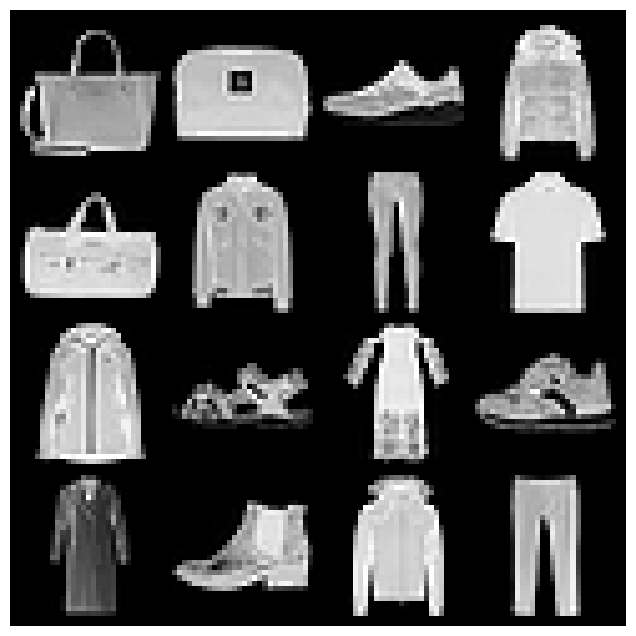

In [6]:
from torchvision.utils import make_grid

# 16 random indices
n_samples = 16
indices = np.random.choice(range(len(train_data)), n_samples, replace=False)
img_samples, labels = train_data.data[indices], train_data.targets[indices]
img_samples = img_samples.unsqueeze(1).float()
labels = [classes[label] for label in labels]

img_grid = torch.mean(make_grid(img_samples, nrow=4), dim=0)

plt.figure(figsize=(8, 8))
plt.imshow(img_grid, cmap="gray")
plt.axis("off")

# Print labels in grid
labels = np.array(labels).reshape(4, 4)
print(labels)

## 2. Prepare Dataloader

Instead of the PyTorch Datasets that our data is currently in, we want to use a PyTorch DataLoader. This is a PyTorch class that allows us to easily iterate over our data in batches. This is useful for memory management and for training our model. Modern hardware cannot handle all of our data at once, so we need to split it up into batches. We will use a batch size of 32.

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


print(f"Train dataloader has {len(train_data_loader)} batches")
print(f"Test dataloader has {len(test_data_loader)} batches")

Train dataloader has 1875 batches
Test dataloader has 313 batches


In [8]:
train_features_batch, train_labels_batch = next(iter(train_data_loader))
print(f"Feature batch shape: {train_features_batch.size()}")
print(f"Labels batch shape: {train_labels_batch.size()}")

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


## 3. Build Baseline Model

In [9]:
class FasionMNISTModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),  # Flattens the height and width of the image
            nn.Linear(in_features=28 * 28, out_features=12),
            nn.ReLU(),
            nn.Linear(in_features=12, out_features=len(classes)),
        )

    def forward(self, x):
        return self.layer_stack(x)


loaded_model = FasionMNISTModelV0().to(device)


parameters = loaded_model.state_dict()
for name, param in parameters.items():
    print(f"{name}: {param.size()}")

layer_stack.1.weight: torch.Size([12, 784])
layer_stack.1.bias: torch.Size([12])
layer_stack.3.weight: torch.Size([10, 12])
layer_stack.3.bias: torch.Size([10])


In [10]:
# Note
img = train_features_batch[0].to(device)
print("One image shape:", img.shape)

# In a batch size of 1, we have 1 image with 1 color channel and 28x28 pixels
batch = img.unsqueeze(0)
print("Batch shape:", batch.shape)

# Flatten will flatten the height and width of the image. Output is batch size x (1*28*28)
flattened = nn.Flatten()(batch)
print("Flattened shape:", flattened.shape)

# So in our model, the image is flattened and then the 784 inputs are passed to
# the linear layer a usual. We get 10 outputs for each image in the batch
output = loaded_model(batch)
print("Output shape:", output.shape)

One image shape: torch.Size([1, 28, 28])
Batch shape: torch.Size([1, 1, 28, 28])
Flattened shape: torch.Size([1, 784])
Output shape: torch.Size([1, 10])


## 4. Train Model

### Create some accuracy and timing metrics

In [11]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=0.01)
acc_fn = Accuracy(task="multiclass", num_classes=len(classes)).to(device)


def print_time(start, end, device):
    total_time = end - start
    print(f"Time: {(total_time):.2f} seconds on {device}")
    return total_time

### Training loop

In [12]:
import time
from tqdm import tqdm

start_time = time.perf_counter()
epochs = 4

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}")
    print("-" * 30)

    train_loss = 0
    for batch, (X, Y) in enumerate(train_data_loader):
        X, Y = X.to(device), Y.to(device)

        loaded_model.train()

        Y_hat = loaded_model(X)

        loss = loss_fn(Y_hat, Y)

        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            completed = batch * len(X)
            total = len(train_data_loader.dataset)
            print(f"Completed {completed}/{total} training examples")

    train_loss /= len(train_data_loader)

    loaded_model.eval()
    with torch.inference_mode():
        test_loss, test_acc = 0, 0
        for X, Y in test_data_loader:
            X, Y = X.to(device), Y.to(device)

            Y_test_hat = loaded_model(X)

            test_loss += loss_fn(Y_test_hat, Y).item()
            test_acc += acc_fn(Y_test_hat, Y).item()

        test_loss /= len(test_data_loader)
        test_acc /= len(test_data_loader)
        test_acc *= 100

    print(
        f"Training loss: {train_loss:.3f}, Test loss: {test_loss:.3f}, Test accuracy: {test_acc:.3f} %"
    )
    print("-" * 30)

end = time.perf_counter()
print_time(start_time, end, device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1
------------------------------
Completed 0/60000 training examples
Completed 12800/60000 training examples
Completed 25600/60000 training examples
Completed 38400/60000 training examples
Completed 51200/60000 training examples


 25%|██▌       | 1/4 [00:07<00:21,  7.26s/it]

Training loss: 0.594, Test loss: 0.549, Test accuracy: 80.471 %
------------------------------
Epoch 2
------------------------------
Completed 0/60000 training examples
Completed 12800/60000 training examples
Completed 25600/60000 training examples
Completed 38400/60000 training examples
Completed 51200/60000 training examples


 50%|█████     | 2/4 [00:14<00:14,  7.11s/it]

Training loss: 0.495, Test loss: 0.527, Test accuracy: 80.970 %
------------------------------
Epoch 3
------------------------------
Completed 0/60000 training examples
Completed 12800/60000 training examples
Completed 25600/60000 training examples
Completed 38400/60000 training examples
Completed 51200/60000 training examples


 75%|███████▌  | 3/4 [00:21<00:06,  6.98s/it]

Training loss: 0.476, Test loss: 0.528, Test accuracy: 81.869 %
------------------------------
Epoch 4
------------------------------
Completed 0/60000 training examples
Completed 12800/60000 training examples
Completed 25600/60000 training examples
Completed 38400/60000 training examples
Completed 51200/60000 training examples


100%|██████████| 4/4 [00:28<00:00,  7.03s/it]

Training loss: 0.466, Test loss: 0.476, Test accuracy: 83.596 %
------------------------------
Time: 28.15 seconds on mps


28.148671707996982

## 5. Evaluate Model

In [13]:
def evaluate_model(model, dataloader, loss_fn, accuracy_fn):
    model.eval()
    with torch.inference_mode():
        loss, acc = 0, 0
        for X, Y in tqdm(dataloader):
            X, Y = X.to(device), Y.to(device)
            Y_pred = model(X)

            loss += loss_fn(Y_pred, Y)
            acc += accuracy_fn(Y_pred, Y)

        loss /= len(dataloader)
        acc /= len(dataloader)
    return {"model": model.__class__.__name__, "loss": loss, "accuracy": acc}


evaluate_model(loaded_model, test_data_loader, loss_fn, acc_fn)

100%|██████████| 313/313 [00:01<00:00, 306.34it/s]


{'model': 'FasionMNISTModelV0',
 'loss': tensor(0.4756, device='mps:0'),
 'accuracy': tensor(0.8360, device='mps:0')}

## 6. Funcitonize

In [14]:
def test_step(model, dataloader, loss_fn, accuracy_fn, device):
    start_time = time.perf_counter()
    model.to(device)
    acc_fn.to(device)
    model.eval()
    with torch.inference_mode():
        loss, acc = 0, 0
        for X_test, Y_test in tqdm(dataloader):
            X_test.to(device), Y_test.to(device)
            Y_pred = model(X)

            loss += loss_fn(Y_pred, Y)
            acc += accuracy_fn(Y_pred, Y)

        loss /= len(dataloader)
        acc = acc / len(dataloader) * 100
        print(f"Test loss: {loss:.3f}, Test accuracy: {acc:.3f} %")
    end_time = time.perf_counter()
    print_time(start_time, end_time, device)


def train_step(model, dataloader, epochs, loss_fn, optimizer, accuracy_fn, device):
    start_time = time.perf_counter()
    model.to(device)
    acc_fn.to(device)
    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch+1}")
        print("-" * 30)
        train_loss, train_acc = 0, 0
        for X_train, Y_train in dataloader:
            X_train, Y_train = X_train.to(device), Y_train.to(device)

            model.train()
            Y_pred = model(X_train)

            batch_loss = loss_fn(Y_pred, Y_train)
            train_loss += batch_loss
            train_acc += accuracy_fn(Y_pred, Y_train)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        train_loss /= len(dataloader)
        train_acc = train_acc / len(dataloader) * 100
        print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f} %")
        print("-" * 30)
    end_time = time.perf_counter()
    print_time(start_time, end_time, device)

In [15]:
seed_everything()
loaded_model = FasionMNISTModelV0()
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=len(classes))
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=0.01)

train_step(loaded_model, train_data_loader, 4, loss_fn, optimizer, acc_fn, device)
test_step(loaded_model, test_data_loader, loss_fn, acc_fn, device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1
------------------------------


 25%|██▌       | 1/4 [00:10<00:30, 10.16s/it]

Training loss: 0.654, Training accuracy: 76.122 %
------------------------------
Epoch 2
------------------------------


 50%|█████     | 2/4 [00:20<00:20, 10.01s/it]

Training loss: 0.565, Training accuracy: 79.950 %
------------------------------
Epoch 3
------------------------------


 75%|███████▌  | 3/4 [00:30<00:10, 10.06s/it]

Training loss: 0.550, Training accuracy: 80.708 %
------------------------------
Epoch 4
------------------------------


100%|██████████| 4/4 [00:39<00:00,  9.93s/it]


Training loss: 0.545, Training accuracy: 81.150 %
------------------------------
Time: 39.74 seconds on mps


100%|██████████| 313/313 [00:01<00:00, 293.92it/s]

Test loss: 0.354, Test accuracy: 87.500 %
Time: 1.07 seconds on mps


## 7. Building a better model (with a CNN)

In [16]:
class FashionMNIST(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_size,
                out_channels=hidden_size,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_size,
                out_channels=hidden_size,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_size,
                out_channels=hidden_size,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_size,
                out_channels=hidden_size,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_size * 7 * 7, out_features=output_size),
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        y = self.classifier(x)
        return y

In [17]:
loaded_model = FashionMNIST(input_size=1, hidden_size=10, output_size=len(classes)).to(
    device
)

parameters = loaded_model.state_dict()
for name, param in parameters.items():
    print(f"{name}: {param.size()}")

conv_block_1.0.weight: torch.Size([10, 1, 3, 3])
conv_block_1.0.bias: torch.Size([10])
conv_block_1.2.weight: torch.Size([10, 10, 3, 3])
conv_block_1.2.bias: torch.Size([10])
conv_block_2.0.weight: torch.Size([10, 10, 3, 3])
conv_block_2.0.bias: torch.Size([10])
conv_block_2.2.weight: torch.Size([10, 10, 3, 3])
conv_block_2.2.bias: torch.Size([10])
classifier.1.weight: torch.Size([10, 490])
classifier.1.bias: torch.Size([10])


## 8. Train better model

In [18]:
seed_everything()
loaded_model = FashionMNIST(input_size=1, hidden_size=10, output_size=len(classes))
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=len(classes))
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=0.01)

epochs = 10
train_step(loaded_model, train_data_loader, epochs, loss_fn, optimizer, acc_fn, device)
test_step(loaded_model, test_data_loader, loss_fn, acc_fn, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
------------------------------


 10%|█         | 1/10 [00:15<02:20, 15.56s/it]

Training loss: 0.456, Training accuracy: 83.313 %
------------------------------
Epoch 2
------------------------------


 20%|██        | 2/10 [00:31<02:03, 15.50s/it]

Training loss: 0.354, Training accuracy: 86.965 %
------------------------------
Epoch 3
------------------------------


 30%|███       | 3/10 [00:46<01:48, 15.44s/it]

Training loss: 0.338, Training accuracy: 87.665 %
------------------------------
Epoch 4
------------------------------


 40%|████      | 4/10 [01:01<01:32, 15.39s/it]

Training loss: 0.333, Training accuracy: 87.808 %
------------------------------
Epoch 5
------------------------------


 50%|█████     | 5/10 [01:17<01:16, 15.37s/it]

Training loss: 0.332, Training accuracy: 87.705 %
------------------------------
Epoch 6
------------------------------


 60%|██████    | 6/10 [01:32<01:01, 15.34s/it]

Training loss: 0.330, Training accuracy: 88.028 %
------------------------------
Epoch 7
------------------------------


 70%|███████   | 7/10 [01:47<00:45, 15.33s/it]

Training loss: 0.326, Training accuracy: 87.997 %
------------------------------
Epoch 8
------------------------------


 80%|████████  | 8/10 [02:02<00:30, 15.33s/it]

Training loss: 0.328, Training accuracy: 87.923 %
------------------------------
Epoch 9
------------------------------


 90%|█████████ | 9/10 [02:18<00:15, 15.40s/it]

Training loss: 0.329, Training accuracy: 88.027 %
------------------------------
Epoch 10
------------------------------


100%|██████████| 10/10 [02:34<00:00, 15.41s/it]


Training loss: 0.334, Training accuracy: 87.783 %
------------------------------
Time: 154.14 seconds on mps


100%|██████████| 313/313 [00:01<00:00, 227.77it/s]

Test loss: 0.379, Test accuracy: 87.500 %
Time: 1.38 seconds on mps


## 9. Visualize results

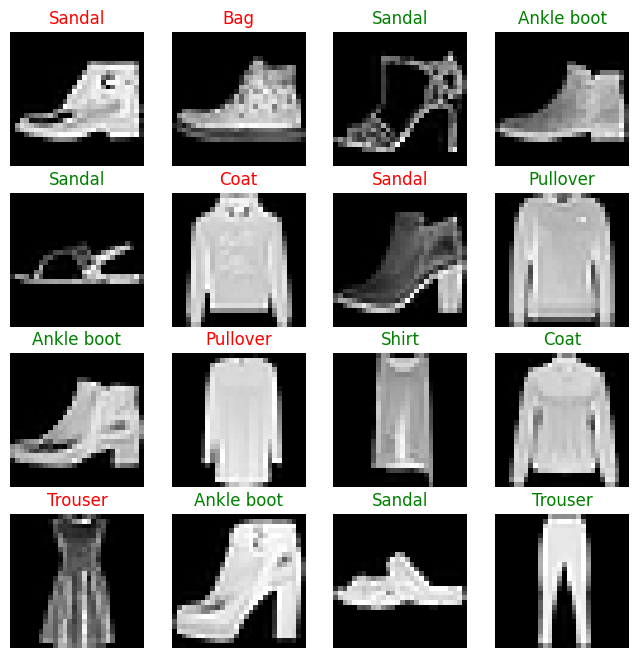

In [22]:
def plot_sample_predictions(model, test_data, classes, device):
    sample_indices = np.random.choice(range(len(test_data)), 16, replace=False)
    sample_images = test_data.data[sample_indices].unsqueeze(1).float().to(device)
    sample_labels = test_data.targets[sample_indices].to(device)

    model.eval()
    model.to(device)
    with torch.inference_mode():
        sample_preds = model(sample_images)
        sample_preds = sample_preds.argmax(dim=1)

        plt.figure(figsize=(8, 8))
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            img = sample_images[i].squeeze().cpu()
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            pred = classes[sample_preds[i]]
            title_color = "green" if pred == classes[sample_labels[i]] else "red"
            plt.title(pred, color=title_color)


plot_sample_predictions(loaded_model, test_data, classes, device)

## 10. Save and Load model

In [23]:
from pathlib import Path

model_dir = Path("models")
model_dir.mkdir(exist_ok=True)

torch.save(loaded_model.state_dict(), model_dir / "03_fashion_mnist_model.pt")

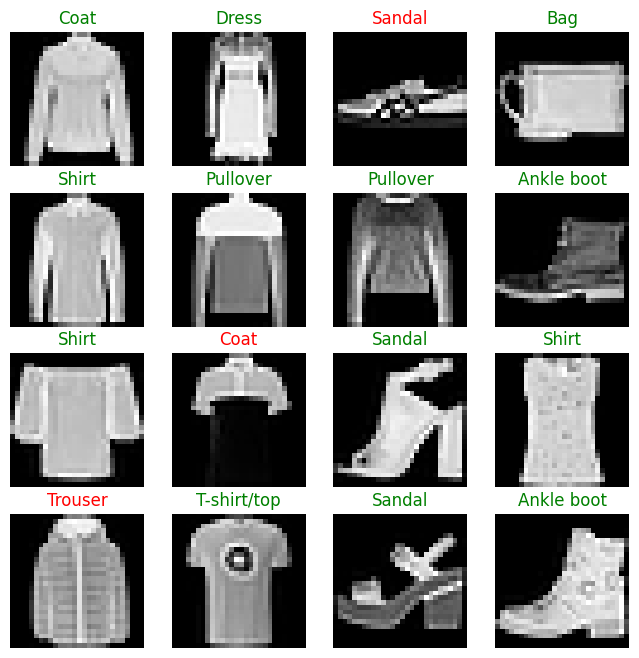

In [24]:
loaded_model = FashionMNIST(input_size=1, hidden_size=10, output_size=len(classes))
loaded_model.load_state_dict(torch.load(model_dir / "03_fashion_mnist_model.pt"))

plot_sample_predictions(loaded_model, test_data, classes, device)

## 11. Confusion Matrix

In [50]:
# Make predictions
loaded_model.eval()
loaded_model.to(device)
with torch.inference_mode():
    test_preds = []
    for X_test, Y_test in tqdm(test_data_loader):
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        Y_test_pred = loaded_model(X_test)
        test_preds.append(Y_test_pred.argmax(dim=1))

    test_preds = torch.cat(test_preds)
    print(f"Test predictions shape: {test_preds.shape}")

100%|██████████| 313/313 [00:00<00:00, 487.21it/s]

Test predictions shape: torch.Size([10000])


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

<Figure size 1000x700 with 0 Axes>

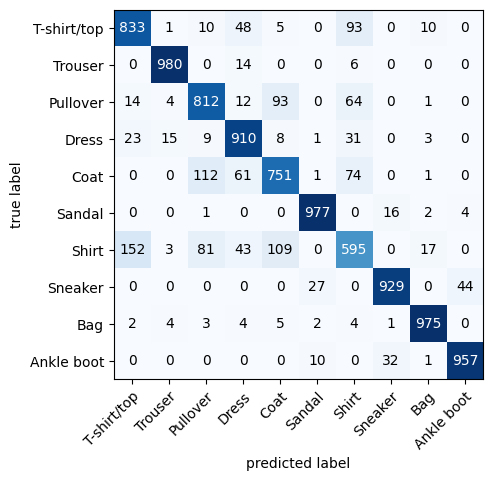

In [51]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

cm = ConfusionMatrix(num_classes=len(classes), task="multiclass").to(device)
cm = cm(test_preds, test_data.targets.to(device))

# Plot
plt.figure(figsize=(10, 7))
plot_confusion_matrix(
    cm.cpu().numpy(),
    class_names=classes,
)